In [106]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)
sns.set_style("darkgrid")

In [190]:
import warnings
warnings.filterwarnings("ignore")

<font color="green" size=6>Задание № 1</font>

## Логика

Вы работаете в отделе контроля качества компании Lego. Есть 30 наборов с деталями. В наборах неодинаковое количество деталей, но в каждом их больше 30. По стандарту, любая деталь должна весить ровно 1 грамм. Вы знаете, что в одном из наборов случился брак, и в нем детали весят по 1,01 грамм. Есть бесконечно точные весы, на которых можно сделать только одно взвешивание. Как за одно взвешивание определить, в каком наборе детали по 1,01 грамм?


### Решение

1-ый набор - берём 1 деталь

2-ой набор - берём 2 детали

...

30-ый набор - берём 30 деталей

Взвешиваем получившийся набор деталей и обращаем внимание лишь на число, после запятой. Далее делим его на 0.01 и получаем то кол-во деталей, которые дают данный остаток, а следовательно и номер того набора, из которого были взяты детали(очевидно, что эти детали бракованные и сам набор является искомым).


<font color="green" size=6>Задание № 2</font>

## Математика + программирование


Дана кусочно-постоянная функция F: (F(x) = a, if x < c else F(x) = b).

Напишите на любом ЯП (предпочтительно Python 3) программу, которая принимает на вход массив A пар (x, y) длины n, и возвращает кортеж из трех элементов (a, b, c), соответствующих параметрам функции F, при которых среднеквадратическое отклонение функции от точек из A минимально.
Визуализация решения приветствуется.


### Размышления

Прежде чем бросаться писать код для решения данной оптимизационной задачи, порассуждаем, как нам действовать в данной ситуации.

Введём обозначения для удобства(и понимания читателю) размышлений:

x_i_left = {x_i | x_i < c}

x_i_right = {x_i | x_i >= c}

F(x): (F(x) = a, if x < c else F(x) = b) - дано по условию

- MSE = 1/n$\sum$(y_i - F(x_i))^2 =  1/n$\sum$(y_i_left - F(x_i_left))^2 + 1/n$\sum$(y_i_right - F(x_i_right))^2 = 1/n$\sum$(y_i_left - a)^2 + 1/n$\sum$(y_i_right - b)^2

- MSE -> min, следовательно, по равенству выше, получаем, что:
1/n$\sum$(y_i_left - a)^2 + 1/n$\sum$(y_i_right - b)^2 -> min, a данная величина принимает минимальное значение, очевидно, когда каждое слагаемое принимает минимальное значение
- В классе константных алгоритмов для mse оптимальным является алгоритм, возвращающий среднее значение. Следовательно, a = mean(y_i_left), b = mean(y_i_right)
- Таким образом, перед нами стоит задача оптимального разбиения данных по порогу с

In [ ]:
# т.к. привычнее пользоваться np.ndarray массивами, то реализуем конвертёр
# для входных данных(если у читателя есть примеры входных данных в формате,
# указанном в задании)

In [197]:
def convert_to_np_array(A:list[tuple[float, float]])->tuple[np.array, np.array]:
    x = []
    y = []
    for elem in A:
        x.append(elem[0])
        y.append(elem[1])
    return np.array(x), np.array(y)

In [198]:
# реализуем также шенерацию данных в виде ступеньки(при необходимости
# в данные можно внести шум)

In [199]:
def generate_step_data(a, b, c, size=100, noise=False):
    n_left = int(size // 2)
    n_right = size - n_left
    
    x_left = np.arange(c-n_left, c+1)
    x_right = np.arange(c, c+n_left)
    
    y_left = np.ones(x_left.shape) * a
    y_right = np.ones(x_right.shape) * b
    
    if noise:
        y_left += np.random.normal(loc=0, scale=0.1, size=y_left.shape)
        y_right += np.random.normal(loc=0, scale=0.1, size=y_right.shape)
        
    x = np.concatenate([x_left, x_right], axis=0)
    y = np.concatenate([y_left, y_right], axis=0)
    
    return x, y

In [200]:
# сгенерируем 2 выборки, одна из которых слегка зашумлена

In [201]:
x_sign, y_sign = generate_step_data(a=-1, b=1, c=0, size=1000)
x_sign_noise, y_sign_noise = generate_step_data(a=-1, b=1, c=0, size=1000,noise=True)

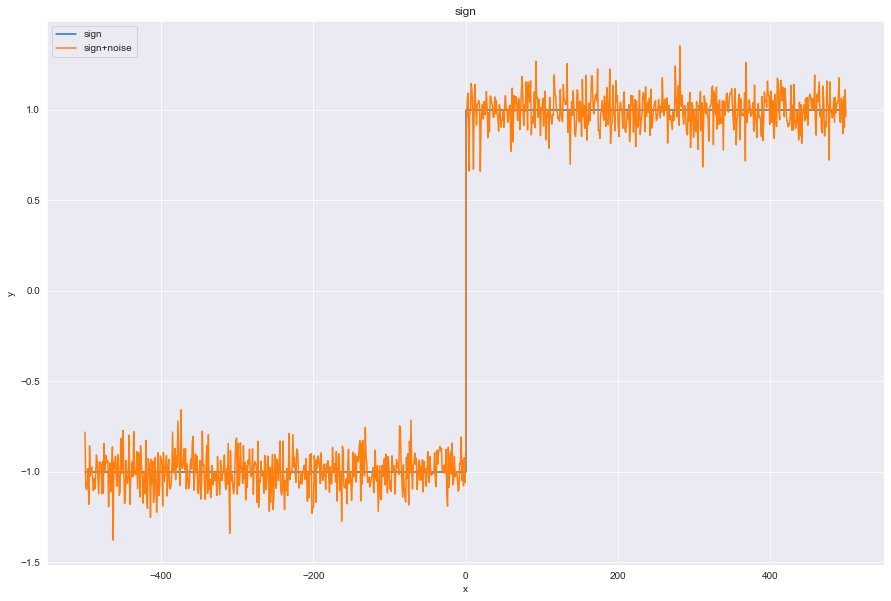

In [202]:
plt.plot(x_sign, y_sign, x_sign_noise, y_sign_noise)
plt.legend(["sign", "sign+noise"], loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("sign")
plt.grid(True)

In [ ]:
# реализуем саму ф-ю для подбора оптимальных параметров a, b, c для входных
# данных

In [203]:
def one_depth_decision_tree_regressor(x, y)->tuple[float, float, float]:
    base_mse = ((y - y.mean())**2).mean()
    a = b = y.mean()
    c = x.min()
    n = len(y)
    
    for threshold in np.unique(x):
        x_left = x[x < threshold]
        x_right = x[x >= threshold]
        
        y_left = y[x < threshold]
        y_right = y[x >= threshold]
        
        a = y_left.mean()
        b = y_right.mean()
        
        left_sse = ((y_left - a)**2).sum()  # sse - sum of squared error
        right_sse = ((y_right - b)**2).sum()
        
        mse = (left_sse + right_sse) / n
        
        if mse < base_mse:
            base_mse = mse
            best_c = threshold
            best_a = a
            best_b = b   
    return best_a, best_b, best_c

In [206]:
a, b, c = one_depth_decision_tree_regressor(x_sign, y_sign)

In [210]:
a_noise, b_noise, c_noise = one_depth_decision_tree_regressor(x_sign_noise, y_sign_noise)

In [209]:
# визуализируем исходные выборки и построенную по этим выборкам ступеньки

In [214]:
x, y = generate_step_data(a, b, c, size=1000)
x_noise, y_noise = generate_step_data(a_noise, b_noise, c_noise, size=1000)

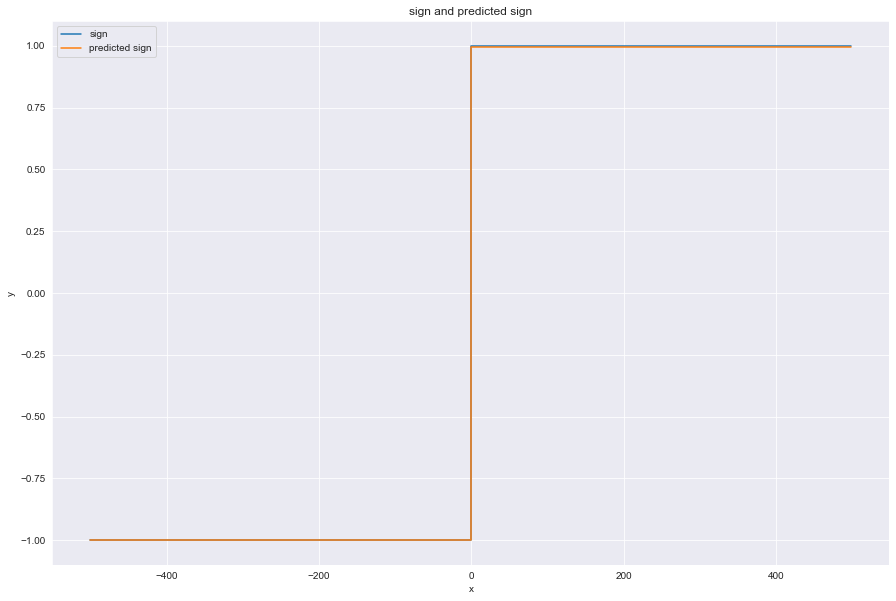

In [215]:
plt.plot(x_sign, y_sign, x, y)
plt.legend(["sign", "predicted sign"], loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("sign and predicted sign")
plt.grid(True)

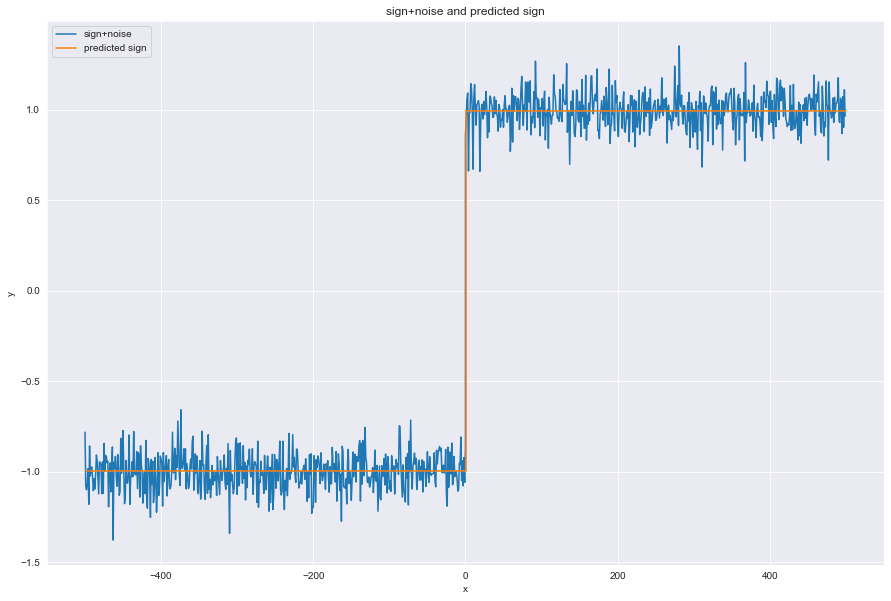

In [216]:
plt.plot(x_sign_noise, y_sign_noise, x_noise, y_noise)
plt.legend(["sign+noise", "predicted sign"], loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("sign+noise and predicted sign")
plt.grid(True)

In [ ]:
# как мы можем заметить оптимальные параметра для разбиения находятся, что можно наблюдать на графиках

# Стоит обратить внимание, что использование именно кусочно-непрерывной функции должно базироваться на некоторых знаниях
# о структуре данных(о законе зависимости tagret от признаков), иначе об адекватной апроксимации данных кусочной непрерывной 
# функцией говорить не приходится

In [224]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [231]:
dec_tree_reg = DecisionTreeRegressor(max_depth=1)
dec_tree_reg.fit(x_sign_noise.reshape(-1, 1), y_sign_noise)

DecisionTreeRegressor(max_depth=1)

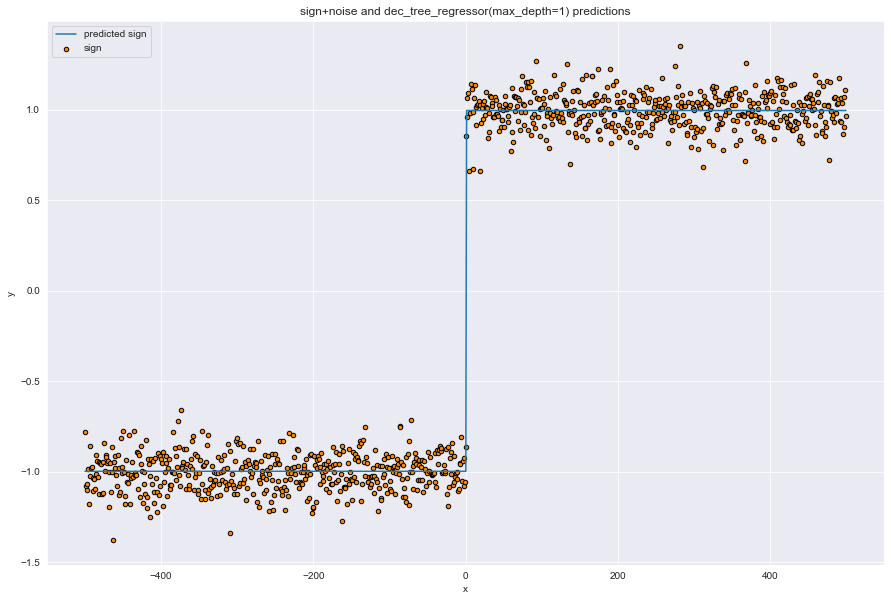

In [241]:
plt.scatter(x_sign_noise, y_sign_noise, s=20, edgecolor="black",
            c="darkorange", label="sign")
plt.plot(x_sign, dec_tree_reg.predict(x_sign.reshape(-1, 1)), label="predicted sign")
plt.title("sign+noise and dec_tree_regressor(max_depth=1) predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper left');

In [ ]:
# как мы можем заметить реализованная нами ранее ф-я - это дерево принятия решений, ограниченное глубиной = 1